# Jina Workshop @ TUM.ai: Building a Neural Image Search Engine

In this workshop we will build a neural search engine for images of Pokemons.

# Downloading data and model

Skip this if you've already downloaded them.

## Download and Extract Data

For this example we're using Pokemon sprites from [veekun.com](https://veekun.com/dex/downloads). To download them run:

```sh
sh ./get_data.sh
```

## Download and Extract Pretrained Model

In this example we use [BiT (Big Transfer) model](https://github.com/google-research/big_transfer), To download it:

```sh
sh ./download.sh
```

# The problem

We want to search Pokemon by pictures! For example 

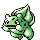

May return

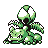 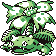

# Code

Required imports

In [ ]:
import os
import sys
from shutil import rmtree

from jina.flow import Flow
from components import *

Some configuration options.

- restrict the nr of docs we index
- the path to the images

In [ ]:
num_docs = int(os.environ.get('JINA_MAX_DOCS', 500))
image_src = 'data/**/*.png'

Environment variables

- workspace (folder where the encoded data will be stored)
- port we will listen on

In [ ]:
workspace = './workspace'
os.environ['JINA_WORKSPACE'] = workspace
os.environ['JINA_PORT'] = os.environ.get('JINA_PORT', str(45678))

We need to make sure to not index on top of an existing workspace. 

This can cause problems if you are using different configuration options between the two runs.

In [ ]:
if os.path.exists(workspace):
    print(f'Workspace at {workspace} exists. Will delete')
    rmtree(workspace)

# Flows

The Flow is the main pipeline in Jina. It describes the way data should be loaded, processed, stored etc. within the system. 

It is made up of components (called Pods), which are the ones doing the specific task.

Ex. we have an Encoder Pod, which loads the model and *encodes* that data; crafter Pod; segmenter Pod etc.

## Index Flow

Depending on your need the Flow can be configured in different ways. 

While indexing (storing) data, we can optimize the pipeline to process the data in parallel

In [ ]:
f = Flow.load_config('flows/index.yml')

In [ ]:
f.plot('index.png')

The Flow is a context manager (like a file handler).

We load data into the pipeline from the directory we provided above. 

`request_size` dictates how many images should be sent in one request (~batching).

In [ ]:
with f:
    f.index_files(image_src, request_size=64, read_mode='rb', size=num_docs)

# Searching

When searching we need to make sure the data is processed in serial manner.

In [ ]:
f = Flow.load_config('flows/query.yml')

In [ ]:
f.plot('search.png')

This will activate the REST API.

You can use [Jinabox.js](https://jina.ai/jinabox.js/) to find the Pokemon which matches most clearly. Just set the endpoint to `http://127.0.0.1:45678/api/search` and drag from the thumbnails on the left or from your file manager.

In [ ]:
with f:
    f.block()

# Questions?

# Advanced Topics


**NOTE**: After configuring these, you will need to re-index your data and search again. 

## 1. Changing Encoders

We can switch the `Encoder` easily.

This is the component that is the actual **model**. This encodes the images into a vector space upon which you can perform cosine similarity (or other linear algebra operations).


`pods/encode.yml`:

```yaml
!ImageKerasEncoder
with:
  model_name: ResNet50V2 # any model could go here
  pool_strategy: avg
  channel_axis: -1
```

## 2. Changing Crafters

These are the components that transform your data. In this case, we crop and resize the image. You can try out other alterations to the images and see if you get better results.

In `pods/craft.yml`:

- remove `target_size: 96` from `ImageNormalizer`

```yaml
- !CenterImageCropper
with:
  target_size: 96
  channel_axis: -1
metas:
  name: img_cropper
```

We also need to specify the request paths, both for `IndexRequest` and for `SearchRequest`:

```yaml
      - !CraftDriver
        with:
          traversal_paths: ['r']
          executor: img_cropper
```

We can save an intermediary file to examine the cropped image to see if everything looks as expected. Add this to the `IndexRequest`:

```yaml
      - !PngToDiskDriver
        with:
          prefix: 'crop'
```

Now you can find the intermediary forms of the file in `workspace/`, under the folders with the given prefix.


# Questions?


## 3. Optimization

In every Flow that is build with Jina, there are quite some parameters to set.
For example, if you use a pre-trained model for encoding, there is no obvious best choice for a given dataset.
Jina allows you to try out a lot of different parameters automatically in order to get the best results.

Therefor, you need to provide Jina some sort of evaluation metric.
In the pokemon dataset, there are two edition with the same pokemon, but different images: `red-blue` and `red-green`.

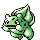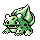

Thus, we will setup the following evaluation metric:
Index one edition and search with the other edition.
We have a success, if the right pokemon is at the first place in the search results.

We need to do the following steps:

- A) build an `index` and a `search` Flow, which are repeaditly runnable
- B) use the `red-blue` dataset for `index` and the `red-green` for `search`
- C) implement an `EvaluationCallback` which will calculate, if the right pokemon is in the first place
- D) set the needed `OptimizationParameter` via a `parameter.yml` file
- E) setup the optimization process itself

**NOTE**: Under the hood, we use [optuna](https://optuna.readthedocs.io/en/stable/) for hyperparameter optimization.

### Do the imports

In [ ]:
import glob
from jina import Document
from jina.optimizers.flow_runner import SingleFlowRunner, MultiFlowRunner
from jina.optimizers import FlowOptimizer, MeanEvaluationCallback

### A) & B)

Jina provides the 
- `SingleFlowRunner` for making a Flow repeaditly runnable and the 
- `MultiFlowRunner` to chain multiple `SingleFlowRunner` for the `FlowOptimizer`

For setup you need:
- `flow_yaml`: the definition of a Flow
- `documents`: the Documents, which are send to the Flow in each optimization step
- `execution_method`: tell the Flow, whether `index` or `search` should be used

Beware, that we introduce `JINA_MODEL_NAME_VAR: ${{JINA_MODEL_NAME}}` in the two new Flow definition.
This variable will allow us to change the model in the Flow in each optimization step.

In [ ]:
def get_input_iterator(edition, full_document):
    image_src = f'data/pokemon/main-sprites/{edition}/*.png'
    for filename in glob.iglob(image_src, recursive=True):
        if full_document:
            with open(filename, 'rb') as fp:
                yield Document(buffer=fp.read(), tags={'filename': filename})
        else:
            yield filename

def get_flows():
    index_flow = SingleFlowRunner(
        flow_yaml='flows/index_opt.yml',
        documents=get_input_iterator('red-blue', True),
        request_size=64,
        execution_method='index',
        overwrite_workspace=True
    )

    search_flow = SingleFlowRunner(
        flow_yaml='flows/query_opt.yml',
        documents=get_input_iterator('red-green', False),
        request_size=64,
        execution_method='search'
    )

    multi_flow = MultiFlowRunner([index_flow, search_flow])
    return multi_flow


### C) implement an `EvaluationCallback` which will calculate, if the right pokemon is in the first place

Since the files are named the same for both editions, we use the filename as an identifier, whether we found the right pokemon.
The `PokemonCallback` checks for each Document, whether the correct result is in the first position.

In [ ]:
def get_id(filename):
    return filename.split('/')[-1].split('.')[0]

class PokemonCallback(MeanEvaluationCallback):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._eval_name = "pokedex_eval"

    def get_empty_copy(self):
        return PokemonCallback(self._eval_name)
    
    def __call__(self, response):
        self._n_docs += len(response.search.docs)
        for doc in response.search.docs:
            if doc.matches:
                document_id = get_id(doc.uri)
                first_match_id = get_id(str(doc.matches[0].tags.fields['filename']))
                if document_id == first_match_id:
                    self._evaluation_values[self._eval_name] += 1

### D) set the needed `OptimizationParameter` via a `parameter.yml` file

We defined in the `parameter_few.yml` the models, that the optimizer should try out.
For demonstation purpose, we just added three models, in order to make the optimizer run rather short.
If you want to try mode models, please use the `parameter.yml` file and increase `n_trials` parameter in the `FlowOptimizer` below

### E) setup the optimization process itself

Finally, we build the `FlowOptimizer` object.
It needs:
- `flow_runner`: the repeaditly runnable Flow object
- `parameter_yaml`: the parameters which the optimizer can change
- `evaluation_callback`: our previously defined evaluation function
- `workspace_base_dir`: A directory for temporary data
- `n_trials`: The amount of optimization steps, that should be performed
- `sampler`: the way, the `FlowOptimizer` should sample new values in each step. For more info please look at the [optuna docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.RandomSampler.html#optuna.samplers.RandomSampler).

In [ ]:

def optimize(flows):
    optimizer = FlowOptimizer(
        flow_runner=flows,
        parameter_yaml='optimize/parameters_few.yml',
        evaluation_callback=PokemonCallback(eval_name='correct'),
        workspace_base_dir='workspace',
        n_trials=3,
        sampler='RandomSampler'
    )
    result = optimizer.optimize_flow()
    result.save_parameters('optimize/best_config.yml')

flows = get_flows()
optimize(flows)